In [1]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm




In [2]:
# ➤ Paths for hyperparameter search: tuning runs, logs, results

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working"

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

os.makedirs(TUNING_DIR, exist_ok=True)

# ➤ Function to create a run-specific directory
def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, activation_fn=None, optimizer_name=None, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    # 👇 Добавим активацию в имя, если она передана
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    # 👇 Добавим имя оптимизатора в имя, если оно передано
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

🛠 Device: cuda


In [3]:
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [4]:
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [5]:
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [6]:
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam"):

    # ----------------------------
    # Ensure CSV file exists and has header
    # ----------------------------
    if not os.path.exists(LOG_CSV_PATH):
        with open(LOG_CSV_PATH, "w") as f:
            f.write("run_id,hidden_dim,lr,batch_size,activation_fn,optimizer_name,R2,MAE,MSE\n")


    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔍 Проверка первых строк X и y
    print("📄 Features (X):")
    print("\n🎯 Target (y):")
    # display(y.head())

    # 📐 Размерности
    print(f"\n✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")


    # ----------------------------
    # K-Fold Cross-Validation
    # ----------------------------
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold + 1} / 5")

        # 📊 Разделение данных
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 🔁 Преобразуем в тензоры
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

        batch_X = X_train_tensor
        batch_y = y_train_tensor
        
        '''
        # 📦 DataLoader с правильным порядком
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        '''
        print("X_train.shape =", X_train.shape)


        # 🧠 Создание новой модели на каждый фолд
        model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
        print("📦 Model is on device:", next(model.parameters()).device)

         # ----------------------------
        # Training loop
        # ----------------------------
        criterion = nn.MSELoss()
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        train_loss_history = []

        # 🔁 Early Stopping init
        early_stopping_patience = 100
        patience_counter = 0
        best_loss = float('inf') 

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            epoch_loss = 0.0

            accumulation_steps = 1  # 🧠 Обновляем веса каждые 1000 батчей
            optimizer.zero_grad()
            epoch_loss = 0.0
                        
            '''
            for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss = loss / accumulation_steps  # 🔁 делим loss, чтобы избежать взрыва градиентов
                loss.backward()
                epoch_loss += loss.item() * accumulation_steps
            
                if (batch_idx + 1) % accumulation_steps != 0:
                    optimizer.step()
                    optimizer.zero_grad()
            '''
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            '''
            current_loss = epoch_loss / len(train_loader)
            '''
            current_loss = loss.item()
            train_loss_history.append(current_loss)

            # 💡 Early Stopping check (выполняется на каждой эпохе)
            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1} — no improvement in {early_stopping_patience} epochs.")
                    break

            # ⏺️ Logging (только раз в 10 эпох)
            if (epoch + 1) % 3000 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}"
                print(log_str)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor)
            metrics = evaluate_regression(y_val_tensor, y_pred)
            fold_metrics.append(metrics)
            print(f"📈 Fold {fold + 1} metrics: {metrics}")

    # ----------------------------
    # Average metrics across folds
    # ----------------------------
    avg_metrics = {
        "MSE": sum(m["MSE"] for m in fold_metrics) / len(fold_metrics),
        "MAE": sum(m["MAE"] for m in fold_metrics) / len(fold_metrics),
        "R2":  sum(m["R2"]  for m in fold_metrics) / len(fold_metrics),
    }
    
    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "activation_fn": activation_fn.__name__,
        "optimizer_name": optimizer_name,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['StdDev']
    }
    config_filename = f"config_{run_id}_ex.json"
    with open(os.path.join(run_dir, config_filename), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{batch_size},{activation_fn.__name__},{optimizer_name},{avg_metrics['R2']:.4f},{avg_metrics['MAE']:.4f},{avg_metrics['MSE']:.6f}\n")

    print(f"\n📊 Average metrics across 5 folds:\n{avg_metrics}")
    return run_id, avg_metrics
    



In [7]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
# hidden_dim_choices = [128]
# hidden_dim_choices = [32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 384]
hidden_dim_choices = [256]

# lr_choices = [0.009]
# lr_choices = [round(lr, 5) for lr in np.arange(0.001, 0.021, 0.001)]
lr_choices = [round(lr, 5) for lr in np.arange(0.003, 0.005, 0.001)]

# batch_size_choices = [64]
# batch_size_choices = [8, 16, 32, 48, 64, 96, 128]
batch_size_choices = [32]


activation_choices = [nn.Tanh]
# activation_choices = [nn.ReLU, nn.LeakyReLU, nn.Tanh]
optimizer_choices = ["Adam"]
# optimizer_choices = ["Adam", "AdamW"]

# 📌 Fixed parameters
EPOCHS = 10000
OUTPUT_DIM = 1
N_RUNS = 10 # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)
    activation_fn=random.choice(activation_choices)
    optimizer_name = random.choice(optimizer_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}, batch size: {batch_size}, activation_fn: {activation_fn.__name__}, optimizer_name: {optimizer_name}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )


🔁 Run 1/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3011/10000 [00:50<01:59, 58.54it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6011/10000 [01:43<01:12, 55.30it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  72%|███████▏  | 7194/10000 [02:04<00:48, 57.61it/s]


⏹️ Early stopping at epoch 7195 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.001485461, 'MAE': 0.027428173, 'R2': 0.7870673178129315}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.84it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  60%|██████    | 6008/10000 [01:47<01:12, 55.37it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  77%|███████▋  | 7723/10000 [02:18<00:40, 55.77it/s]


⏹️ Early stopping at epoch 7724 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.001684265, 'MAE': 0.030272845, 'R2': 0.7577880279600651}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.80it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6006/10000 [01:47<01:11, 55.85it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  69%|██████▉   | 6933/10000 [02:04<00:54, 55.82it/s]


⏹️ Early stopping at epoch 6934 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0016543227, 'MAE': 0.030718999, 'R2': 0.7641343821731398}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.72it/s]

Epoch [3000/10000], Loss: 0.0039


Epochs:  60%|██████    | 6008/10000 [01:44<01:09, 57.70it/s]

Epoch [6000/10000], Loss: 0.0023


Epochs:  65%|██████▌   | 6517/10000 [01:52<01:00, 57.75it/s]


⏹️ Early stopping at epoch 6518 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002245482, 'MAE': 0.03262039, 'R2': 0.6700123092285297}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.52it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6008/10000 [01:44<01:09, 57.73it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  80%|███████▉  | 7974/10000 [02:18<00:35, 57.68it/s]


⏹️ Early stopping at epoch 7975 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0015474164, 'MAE': 0.028632874, 'R2': 0.7745430905597783}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0017233894439414143, 'MAE': 0.029934655874967575, 'R2': 0.7507090255468889}

🔁 Run 2/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  20%|██        | 2010/10000 [00:35<02:22, 55.92it/s]


⏹️ Early stopping at epoch 2011 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0043644086, 'MAE': 0.048919834, 'R2': 0.3743860074100058}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.80it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  60%|██████    | 6006/10000 [01:47<01:11, 55.57it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  70%|██████▉   | 6961/10000 [02:04<00:54, 55.77it/s]


⏹️ Early stopping at epoch 6962 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0016414197, 'MAE': 0.028625702, 'R2': 0.7639495682940548}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.78it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  60%|██████    | 6006/10000 [01:47<01:11, 55.90it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  69%|██████▉   | 6936/10000 [02:04<00:54, 55.80it/s]


⏹️ Early stopping at epoch 6937 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0022573604, 'MAE': 0.035430487, 'R2': 0.6781560892517948}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|██▉       | 2965/10000 [00:51<02:01, 57.74it/s]


⏹️ Early stopping at epoch 2966 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.003107098, 'MAE': 0.040991668, 'R2': 0.5433924776862196}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:00, 57.84it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  60%|██████    | 6008/10000 [01:43<01:09, 57.69it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  71%|███████   | 7073/10000 [02:02<00:50, 57.76it/s]


⏹️ Early stopping at epoch 7074 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0017103908, 'MAE': 0.028308427, 'R2': 0.7507979227696734}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0026161354733631017, 'MAE': 0.03645522370934486, 'R2': 0.6221364130823497}

🔁 Run 3/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.85it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  60%|██████    | 6008/10000 [01:47<01:11, 55.61it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  76%|███████▌  | 7605/10000 [02:16<00:42, 55.77it/s]


⏹️ Early stopping at epoch 7606 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.004076481, 'MAE': 0.0495776, 'R2': 0.41565886524915074}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.87it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6006/10000 [01:47<01:12, 55.45it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  79%|███████▉  | 7900/10000 [02:22<00:37, 55.63it/s]


⏹️ Early stopping at epoch 7901 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0015292106, 'MAE': 0.02667684, 'R2': 0.7800861852253513}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.71it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  60%|██████    | 6006/10000 [01:47<01:11, 55.54it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  76%|███████▌  | 7564/10000 [02:15<00:43, 55.79it/s]


⏹️ Early stopping at epoch 7565 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0014933402, 'MAE': 0.026771827, 'R2': 0.7870865191499838}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:51<02:00, 57.89it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  60%|██████    | 6008/10000 [01:43<01:09, 57.78it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  72%|███████▏  | 7157/10000 [02:03<00:49, 57.81it/s]


⏹️ Early stopping at epoch 7158 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.001431784, 'MAE': 0.027159022, 'R2': 0.7895903719017634}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.68it/s]

Epoch [3000/10000], Loss: 0.0038


Epochs:  42%|████▏     | 4179/10000 [01:12<01:40, 57.76it/s]


⏹️ Early stopping at epoch 4180 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0024145995, 'MAE': 0.037986625, 'R2': 0.6481954930582563}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0021890830481424927, 'MAE': 0.033634382858872415, 'R2': 0.6841234869169012}

🔁 Run 4/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:54<02:06, 55.40it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6008/10000 [01:48<01:11, 55.82it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  62%|██████▏   | 6212/10000 [01:51<01:08, 55.53it/s]


⏹️ Early stopping at epoch 6213 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0018094375, 'MAE': 0.028789207, 'R2': 0.7406270464910232}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  26%|██▌       | 2595/10000 [00:45<02:08, 57.67it/s]


⏹️ Early stopping at epoch 2596 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0030676576, 'MAE': 0.04017213, 'R2': 0.5588441036414855}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.83it/s]

Epoch [3000/10000], Loss: 0.0037


Epochs:  60%|██████    | 6006/10000 [01:47<01:11, 55.97it/s]

Epoch [6000/10000], Loss: 0.0029


Epochs:  62%|██████▏   | 6196/10000 [01:50<01:08, 55.86it/s]


⏹️ Early stopping at epoch 6197 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0028857943, 'MAE': 0.041202925, 'R2': 0.5885568520891449}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:53<02:05, 55.89it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  60%|██████    | 6007/10000 [01:47<01:11, 55.60it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  86%|████████▌ | 8563/10000 [02:33<00:25, 55.71it/s]


⏹️ Early stopping at epoch 8564 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0016220445, 'MAE': 0.028170545, 'R2': 0.7616303709927437}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:00, 57.91it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  46%|████▌     | 4592/10000 [01:19<01:33, 57.77it/s]


⏹️ Early stopping at epoch 4593 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0020427066, 'MAE': 0.032515842, 'R2': 0.702379869739153}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002285528089851141, 'MAE': 0.03417012989521027, 'R2': 0.67040764859071}

🔁 Run 5/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.85it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  43%|████▎     | 4265/10000 [01:16<01:42, 55.79it/s]


⏹️ Early stopping at epoch 4266 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.003540855, 'MAE': 0.04491469, 'R2': 0.49243788968895486}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.74it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6007/10000 [01:44<01:09, 57.74it/s]


Epoch [6000/10000], Loss: 0.0019
⏹️ Early stopping at epoch 6008 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0019802214, 'MAE': 0.03194222, 'R2': 0.7152269192114536}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.88it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  32%|███▏      | 3174/10000 [00:56<02:02, 55.72it/s]


⏹️ Early stopping at epoch 3175 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0029760136, 'MAE': 0.039635863, 'R2': 0.5756938676253821}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.78it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  60%|██████    | 6006/10000 [01:47<01:11, 55.91it/s]

Epoch [6000/10000], Loss: 0.0027


Epochs:  71%|███████▏  | 7127/10000 [02:07<00:51, 55.87it/s]


⏹️ Early stopping at epoch 7128 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0021082868, 'MAE': 0.031741742, 'R2': 0.6901740240654621}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  29%|██▊       | 2855/10000 [00:49<02:03, 57.86it/s]


⏹️ Early stopping at epoch 2856 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002898971, 'MAE': 0.03923291, 'R2': 0.5776230490726104}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0027008695527911187, 'MAE': 0.03749348446726799, 'R2': 0.6102311499327727}

🔁 Run 6/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.84it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  50%|████▉     | 4964/10000 [01:28<01:30, 55.84it/s]


⏹️ Early stopping at epoch 4965 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0022499787, 'MAE': 0.031942703, 'R2': 0.6774778856094155}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.67it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6008/10000 [01:44<01:09, 57.63it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  62%|██████▏   | 6156/10000 [01:46<01:06, 57.72it/s]


⏹️ Early stopping at epoch 6157 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0023871036, 'MAE': 0.04005742, 'R2': 0.6567136936208025}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:04, 56.05it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  45%|████▍     | 4483/10000 [01:20<01:38, 55.86it/s]


⏹️ Early stopping at epoch 4484 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0022296906, 'MAE': 0.03246302, 'R2': 0.6821010764496518}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.66it/s]

Epoch [3000/10000], Loss: 0.0044


Epochs:  60%|██████    | 6006/10000 [01:47<01:12, 55.45it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  86%|████████▌ | 8592/10000 [02:34<00:25, 55.70it/s]


⏹️ Early stopping at epoch 8593 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0013979188, 'MAE': 0.025670877, 'R2': 0.7945670526501893}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  21%|██        | 2102/10000 [00:36<02:16, 57.80it/s]


⏹️ Early stopping at epoch 2103 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0041297325, 'MAE': 0.04777509, 'R2': 0.39830244564606043}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002478884835727513, 'MAE': 0.0355818223208189, 'R2': 0.6418324307952238}

🔁 Run 7/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:54<02:05, 55.81it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6008/10000 [01:48<01:11, 55.55it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  61%|██████    | 6104/10000 [01:49<01:10, 55.61it/s]


⏹️ Early stopping at epoch 6105 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0015802989, 'MAE': 0.026870184, 'R2': 0.7734728212988262}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.64it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  34%|███▎      | 3360/10000 [00:58<01:55, 57.73it/s]


⏹️ Early stopping at epoch 3361 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0023784277, 'MAE': 0.03490852, 'R2': 0.6579613794358707}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:06, 55.48it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  49%|████▉     | 4942/10000 [01:28<01:30, 55.66it/s]


⏹️ Early stopping at epoch 4943 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0016031367, 'MAE': 0.027550025, 'R2': 0.7714322388092031}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.59it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  50%|████▉     | 4984/10000 [01:29<01:30, 55.73it/s]


⏹️ Early stopping at epoch 4985 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002165798, 'MAE': 0.03291032, 'R2': 0.6817223918486182}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  19%|█▉        | 1875/10000 [00:32<02:20, 57.82it/s]


⏹️ Early stopping at epoch 1876 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0039795972, 'MAE': 0.04693405, 'R2': 0.4201770263900342}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0023414517054334283, 'MAE': 0.03383461944758892, 'R2': 0.6609531715565105}

🔁 Run 8/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.76it/s]

Epoch [3000/10000], Loss: 0.0041


Epochs:  60%|██████    | 6008/10000 [01:47<01:11, 55.99it/s]

Epoch [6000/10000], Loss: 0.0026


Epochs:  67%|██████▋   | 6688/10000 [01:59<00:59, 55.88it/s]


⏹️ Early stopping at epoch 6689 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.002749871, 'MAE': 0.035958543, 'R2': 0.6058210617971889}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:00, 57.83it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6008/10000 [01:44<01:09, 57.69it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  64%|██████▍   | 6375/10000 [01:50<01:02, 57.75it/s]


⏹️ Early stopping at epoch 6376 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0028985273, 'MAE': 0.03745046, 'R2': 0.5831664772205204}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.57it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  51%|█████     | 5111/10000 [01:31<01:27, 55.77it/s]


⏹️ Early stopping at epoch 5112 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0025555287, 'MAE': 0.034213834, 'R2': 0.6356446101164688}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.92it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  34%|███▍      | 3390/10000 [01:00<01:58, 55.81it/s]


⏹️ Early stopping at epoch 3391 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002170197, 'MAE': 0.033036746, 'R2': 0.6810759243832502}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.78it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  60%|██████    | 6006/10000 [01:47<01:12, 55.42it/s]

Epoch [6000/10000], Loss: 0.0023


Epochs:  76%|███████▋  | 7634/10000 [02:16<00:42, 55.79it/s]


⏹️ Early stopping at epoch 7635 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0019927227, 'MAE': 0.03366031, 'R2': 0.7096624565655167}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0024733693338930608, 'MAE': 0.03486397862434387, 'R2': 0.643074106016589}

🔁 Run 9/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.77it/s]

Epoch [3000/10000], Loss: 0.0041


Epochs:  59%|█████▉    | 5891/10000 [01:45<01:13, 55.81it/s]


⏹️ Early stopping at epoch 5892 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0023350262, 'MAE': 0.036889218, 'R2': 0.665286785061517}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:00, 57.80it/s]

Epoch [3000/10000], Loss: 0.0022


Epochs:  46%|████▌     | 4608/10000 [01:19<01:33, 57.79it/s]


⏹️ Early stopping at epoch 4609 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0018353985, 'MAE': 0.029674234, 'R2': 0.7360537035718147}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:04, 56.04it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  42%|████▏     | 4178/10000 [01:14<01:44, 55.84it/s]


⏹️ Early stopping at epoch 4179 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.002391035, 'MAE': 0.034616962, 'R2': 0.6590973852187425}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:53<02:05, 55.57it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  53%|█████▎    | 5308/10000 [01:35<01:24, 55.85it/s]


⏹️ Early stopping at epoch 5309 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0031413427, 'MAE': 0.046038292, 'R2': 0.5383600442152725}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:51<02:00, 57.90it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  52%|█████▏    | 5159/10000 [01:29<01:23, 57.85it/s]


⏹️ Early stopping at epoch 5160 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0025256865, 'MAE': 0.039537482, 'R2': 0.6320102243363317}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002445697761140764, 'MAE': 0.03735123760998249, 'R2': 0.6461616284807358}

🔁 Run 10/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:53<02:05, 55.88it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  36%|███▌      | 3561/10000 [01:03<01:55, 55.78it/s]


⏹️ Early stopping at epoch 3562 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0023145697, 'MAE': 0.034142874, 'R2': 0.6682191197036879}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.59it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  52%|█████▏    | 5199/10000 [01:33<01:26, 55.76it/s]


⏹️ Early stopping at epoch 5200 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.004314393, 'MAE': 0.056319613, 'R2': 0.37955269365079203}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:53<02:05, 55.65it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  44%|████▍     | 4401/10000 [01:18<01:40, 55.82it/s]


⏹️ Early stopping at epoch 4402 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0024651843, 'MAE': 0.03703694, 'R2': 0.648525507091819}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  25%|██▌       | 2504/10000 [00:43<02:09, 57.80it/s]


⏹️ Early stopping at epoch 2505 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0041075177, 'MAE': 0.0476686, 'R2': 0.39637453486875207}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:52<02:01, 57.58it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  34%|███▎      | 3368/10000 [00:58<01:54, 57.71it/s]

⏹️ Early stopping at epoch 3369 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0026683586, 'MAE': 0.036254473, 'R2': 0.6112230310406179}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0031740046106278896, 'MAE': 0.04228449985384941, 'R2': 0.5407789772711338}


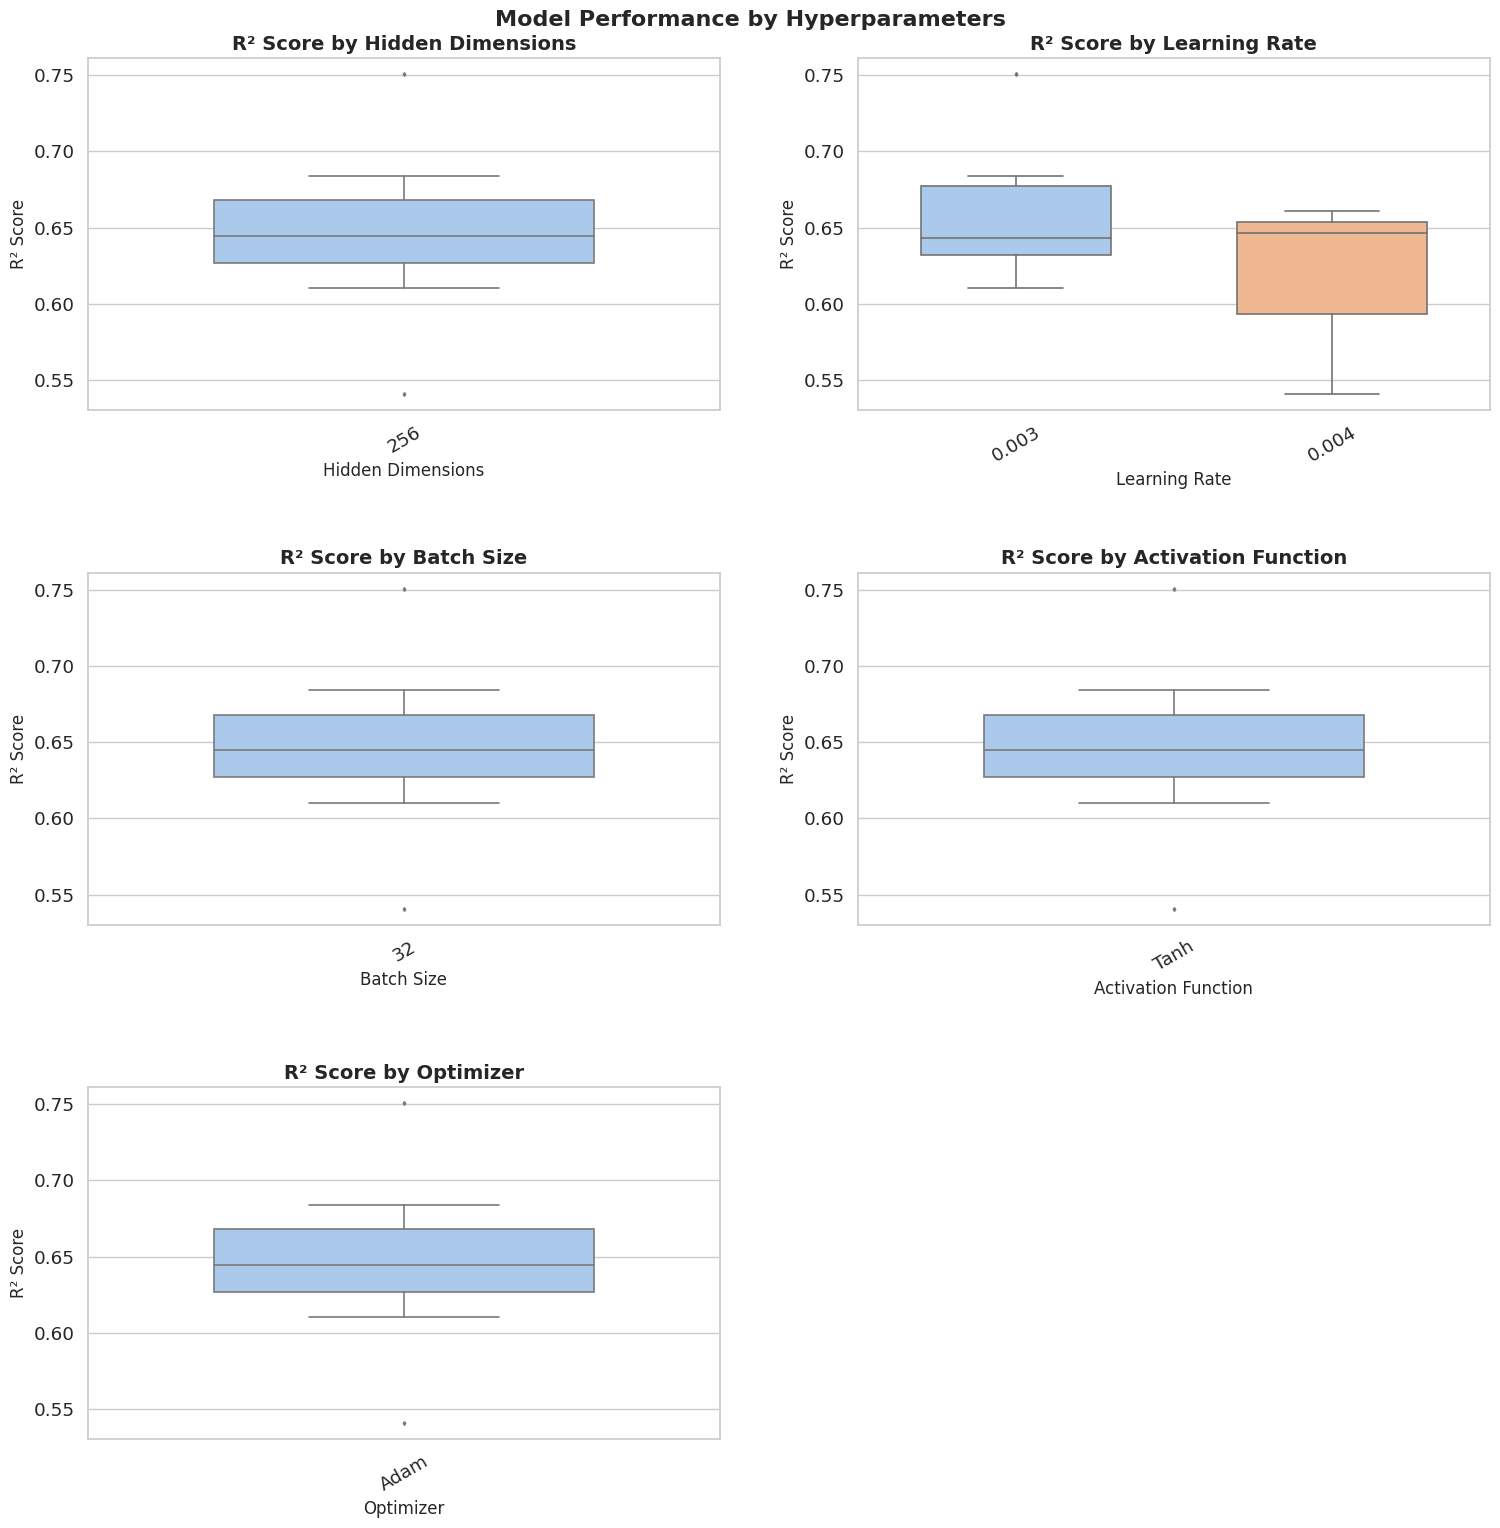


Best Configuration:
Run ID        : mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam
Hidden Dim    : 256
Learning Rate : 0.00300
Batch Size    : 32
Activation Fn : Tanh
Optimizer     : Adam
R² Score      : 0.7507
MAE           : 0.0299
MSE           : 0.001723


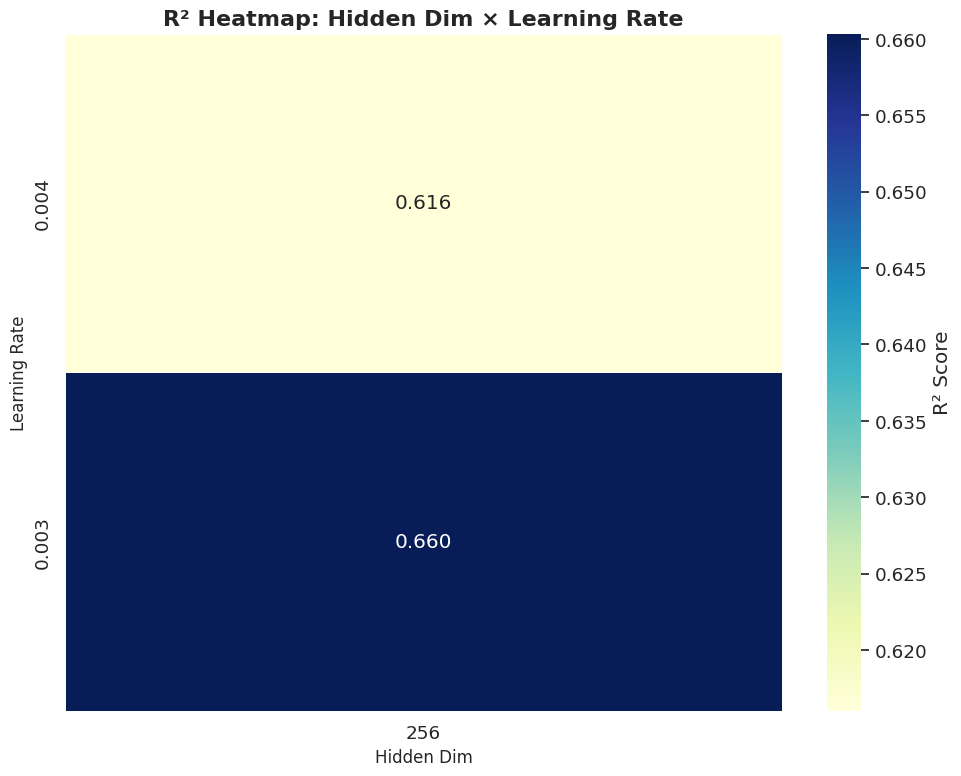


 R² threshold (95% of max): 0.7132
🔍 Found 1 stable candidates:

   hidden_dim     lr  batch_size activation_fn optimizer_name      R2     MAE  \
0         256  0.003          32          Tanh           Adam  0.7507  0.0299   

        MSE  
0  0.001723  


In [8]:
# 📁 src/tuning/visualize_search_results.py
# ➞ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📅 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH)

# Современный стиль
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Создаём 3×2 подграфика
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Список параметров и названий
plot_params = [
    ("hidden_dim", "Hidden Dimensions"),
    ("lr", "Learning Rate"),
    ("batch_size", "Batch Size"),
    ("activation_fn", "Activation Function"),
    ("optimizer_name", "Optimizer")
]

# Строим графики
for i, (param, label) in enumerate(plot_params):
    ax = axes[i]
    sns.boxplot(x=param, y="R2", data=df_log, ax=ax, width=0.6, fliersize=2, linewidth=1.2)
    ax.set_title(f"R² Score by {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("R² Score", fontsize=12)
    ax.xaxis.set_tick_params(rotation=30)

# Удаляем последний пустой subplot, если графиков меньше
if len(axes) > len(plot_params):
    fig.delaxes(axes[-1])

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.95)
fig.suptitle("Model Performance by Hyperparameters", fontsize=16, fontweight='bold')

plt.show()

# Выводим лучшую конфигурацию
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\nBest Configuration:")
print(f"Run ID        : {best_row['run_id']}")
print(f"Hidden Dim    : {int(best_row['hidden_dim'])}")
print(f"Learning Rate : {best_row['lr']:.5f}")
print(f"Batch Size    : {int(best_row['batch_size'])}")
print(f"Activation Fn : {best_row['activation_fn']}")
print(f"Optimizer     : {best_row['optimizer_name']}")
print(f"R² Score      : {best_row['R2']:.4f}")
print(f"MAE           : {best_row['MAE']:.4f}")
print(f"MSE           : {best_row['MSE']:.6f}")

# ------------------------------
# 🔥 Heatmap of R² by hidden_dim × learning rate
# ------------------------------

# Группируем по hidden_dim и lr, берём среднее R²
pivot_table = df_log.pivot_table(
    values="R2",
    index="lr",         # строки — learning rate
    columns="hidden_dim",  # колонки — hidden_dim
    aggfunc="mean"
)

# Сортируем для лучшей читаемости
pivot_table = pivot_table.sort_index(ascending=False)

# Отрисовка
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "R² Score"})
plt.title("R² Heatmap: Hidden Dim × Learning Rate", fontsize=16, fontweight='bold')
plt.xlabel("Hidden Dim", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "batch_size", "activation_fn", "optimizer_name", "R2", "MAE", "MSE"]])
